In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PreyPredPolicy import PreyPolicy, PreyPredPolicy
from models.ModularNetworks import PredatorInteraction
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation
from custom_marl_aquarium.aquarium_v0 import parallel_env

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# aus deinem couzin_utils.py übernommen/benutzt:
# - Agent
# - rotation_matrix_about
# - enforce_walls
# - get_features_from_logs

def _discrete_to_angle(discrete_action: int, action_count: int = 360) -> float:
    # map {0..action_count-1} -> [-pi, pi)
    return (discrete_action / action_count) * (2 * np.pi) - np.pi

def _turn_towards(current_vel: np.ndarray, desired_dir: np.ndarray, max_turn: float) -> np.ndarray:
    """
    current_vel: (3,)
    desired_dir: (3,) normed (or close)
    max_turn: rad per step
    """
    cv = current_vel.copy()
    if np.linalg.norm(cv) < 1e-12:
        # fallback: if zero vel, just set direction
        return desired_dir

    cv = cv / (np.linalg.norm(cv) + 1e-12)
    dd = desired_dir / (np.linalg.norm(desired_dir) + 1e-12)

    # angle between
    dot = np.clip(np.dot(cv, dd), -1.0, 1.0)
    angle = np.arccos(dot)

    if angle <= max_turn:
        return dd

    # rotate around z-axis in 2d (or around cross axis generally)
    axis = np.cross(cv, dd)
    if np.linalg.norm(axis) < 1e-12:
        # parallel/opposite: pick z axis
        axis = np.array([0.0, 0.0, 1.0], dtype=np.float32)
    rot = rotation_matrix_about(axis, max_turn)
    new_dir = (np.asmatrix(cv) * rot).A1
    new_dir = new_dir / (np.linalg.norm(new_dir) + 1e-12)
    return new_dir

class CouzinPolicyEnv:
    """
    Minimaler Wrapper, um Couzin-Welt wie ein 'env' zu benutzen:
    - env.step(action_dict): setzt velocities gemäß actions und bewegt
    - env.render(): optional quiver plot
    - env.agents: list der agent-namen im Stil predator_0, prey_0..prey_{n-1}
    """
    def __init__(
        self,
        n_preys=32,
        n_sharks=1,
        dt=0.5,
        constant_speed=15.0,
        shark_speed=15.0,
        theta_dot_max=0.5,
        theta_dot_max_shark=0.3,
        area_width=2160,
        area_height=2160,
        area_depth=50,
        dimension="2d",
        visualization=True
    ):
        self.n_preys = n_preys
        self.n_sharks = n_sharks
        self.dt = dt
        self.constant_speed = float(constant_speed)
        self.shark_speed = float(shark_speed)
        self.theta_dot_max = float(theta_dot_max)
        self.theta_dot_max_shark = float(theta_dot_max_shark)
        self.area_width = float(area_width)
        self.area_height = float(area_height)
        self.area_depth = float(area_depth)
        self.dimension = dimension
        self.visualization = visualization

        # create agents
        self.swarm = [Agent(i, self.constant_speed, self.area_width, self.area_height, self.area_depth, dimension=self.dimension)
                      for i in range(self.n_preys)]
        self.sharks = [Agent(i, self.shark_speed, self.area_width, self.area_height, self.area_depth, dimension=self.dimension)
                       for i in range(self.n_sharks)]

        self.agents = ["predator_0"] + [f"prey_{i}" for i in range(self.n_preys)]

        self._fig = None
        self._ax = None

    def close(self):
        if self._fig is not None:
            plt.close(self._fig)
        self._fig, self._ax = None, None

    def _ensure_fig(self):
        if not self.visualization:
            return
        if self._fig is None:
            self._fig, self._ax = plt.subplots()
            self._ax.set_aspect("equal", "box")

    def render(self):
        if not self.visualization:
            return
        self._ensure_fig()
        ax = self._ax
        ax.clear()

        swarm_pos = np.array([a.pos for a in self.swarm], dtype=np.float32)
        swarm_vel = np.array([a.vel for a in self.swarm], dtype=np.float32)
        sharks_pos = np.array([s.pos for s in self.sharks], dtype=np.float32)

        ax.quiver(swarm_pos[:, 0], swarm_pos[:, 1], swarm_vel[:, 0], swarm_vel[:, 1], angles="xy", scale_units="xy", scale=1.0)
        ax.plot(sharks_pos[:, 0], sharks_pos[:, 1], "o")

        ax.set_xlim(0, self.area_width)
        ax.set_ylim(0, self.area_height)
        plt.pause(0.00000001)

    def _build_logs_step(self):
        # Format wie in couzin_utils.run_couzin_simulation: [x,y,vx,vy,dirx,diry]
        prey_log_step = np.zeros((self.n_preys, 6), dtype=np.float32)
        shark_log_step = np.zeros((self.n_sharks, 6), dtype=np.float32)

        for i, a in enumerate(self.swarm):
            vx, vy = float(a.vel[0]), float(a.vel[1])
            vnorm = np.sqrt(vx*vx + vy*vy)
            if vnorm > 1e-12:
                dirx, diry = vx / vnorm, vy / vnorm
            else:
                dirx, diry = 0.0, 0.0
            prey_log_step[i] = [float(a.pos[0]), float(a.pos[1]), vx, vy, dirx, diry]

        for i, s in enumerate(self.sharks):
            vx, vy = float(s.vel[0]), float(s.vel[1])
            vnorm = np.sqrt(vx*vx + vy*vy)
            if vnorm > 1e-12:
                dirx, diry = vx / vnorm, vy / vnorm
            else:
                dirx, diry = 0.0, 0.0
            shark_log_step[i] = [float(s.pos[0]), float(s.pos[1]), vx, vy, dirx, diry]

        return prey_log_step, shark_log_step

    def step(self, action_dict, action_count=360):
        """
        action_dict: {'predator_0': int, 'prey_0': int, ..., 'prey_{n-1}': int}
        """
        # --- apply predator action ---
        if self.n_sharks > 0 and "predator_0" in action_dict:
            a = int(action_dict["predator_0"])
            theta = _discrete_to_angle(a, action_count=action_count)
            desired_dir = np.array([np.cos(theta), np.sin(theta), 0.0], dtype=np.float32)
            cur_vel = self.sharks[0].vel.astype(np.float32)
            new_dir = _turn_towards(cur_vel, desired_dir, max_turn=self.theta_dot_max_shark * self.dt)
            self.sharks[0].vel = new_dir * self.shark_speed

        # --- apply prey actions ---
        for i in range(self.n_preys):
            key = f"prey_{i}"
            if key not in action_dict:
                continue
            a = int(action_dict[key])
            theta = _discrete_to_angle(a, action_count=action_count)
            desired_dir = np.array([np.cos(theta), np.sin(theta), 0.0], dtype=np.float32)
            cur_vel = self.swarm[i].vel.astype(np.float32)
            new_dir = _turn_towards(cur_vel, desired_dir, max_turn=self.theta_dot_max * self.dt)
            self.swarm[i].vel = new_dir * self.constant_speed

        # --- walls & movement ---
        for agent in self.swarm:
            enforce_walls(agent, self.area_width, self.area_height)
            agent.update_position(self.dt)

        for shark in self.sharks:
            enforce_walls(shark, self.area_width, self.area_height)
            shark.update_position(self.dt)

    def get_eval_features(self):
        prey_log_step, shark_log_step = self._build_logs_step()
        pred_tensor, prey_tensor, metrics = get_features_from_logs(
            prey_log_step,
            shark_log_step,
            area_width=self.area_width,
            area_height=self.area_height,
            constant_speed=self.constant_speed,
            shark_speed=self.shark_speed,
            expert_height=2160,
            expert_width=2160,
            expert_speed=15
        )

        xs = metrics["xs"]
        ys = metrics["ys"]
        dx = metrics["dx"]
        dy = metrics["dy"]
        vxs = metrics["vxs"]
        vys = metrics["vys"]

        # directions: (N,2) aus theta (pred + preys)
        # theta_norm in features[...,4] ist theta/pi (normiert).
        # reconstruct direction approx:
        thetas = (metrics["features"][:, 0, 4] * np.pi)  # irgendeine Spalte reicht, theta ist pro agent konstant
        directions = np.stack([np.cos(thetas), np.sin(thetas)], axis=-1).astype(np.float32)

        return pred_tensor, prey_tensor, xs, ys, directions, dx, dy, vxs, vys


In [2]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Couzin Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy().to(device)
prey_policy.set_parameters(init=True)

prey_pred_policy = PreyPredPolicy().to(device)
prey_pred_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=250000, device="cpu")

start_frame_pool = Pool(max_length=12100, device="cpu")
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(couzin_path)

len_exp_pred, len_exp_prey, len_exp_pred_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey)
print("Storage of Prey Pred Expert Buffer: ", len_exp_pred_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  7510
Storage of Prey Expert Buffer:  240320
Storage of Prey Pred Expert Buffer:  240320 



In [5]:
pred_policy = pretrain_policy(pred_policy, expert_buffer, role="predator", pred_bs=1024, prey_bs=4096, prey_pred_bs=1024, epochs=250, lr=1e-3, device=device)

In [6]:
prey_policy = pretrain_policy(prey_policy, expert_buffer, role="prey", pred_bs=1024, prey_bs=4096, prey_pred_bs=1024, epochs=300, lr=1e-3, device=device)

In [7]:
prey_pred_policy = pretrain_policy(prey_pred_policy, expert_buffer, role="prey_pred", pred_bs=1024, prey_bs=4096, prey_pred_bs=4096, epochs=300, lr=1e-3, device=device)

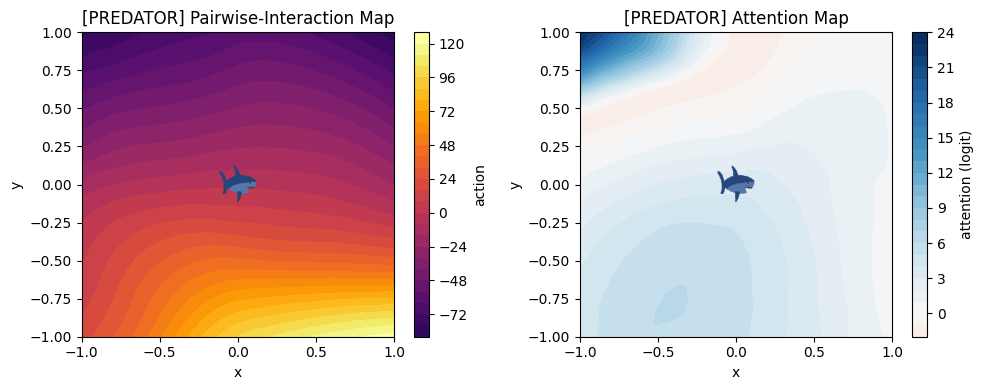

In [8]:
xs, ys, pred_action_map, pred_attn_map = compute_pin_an_maps(pin=pred_policy.pairwise, an=pred_policy.attention)

pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, role="predator", img_path=pred_img_path)

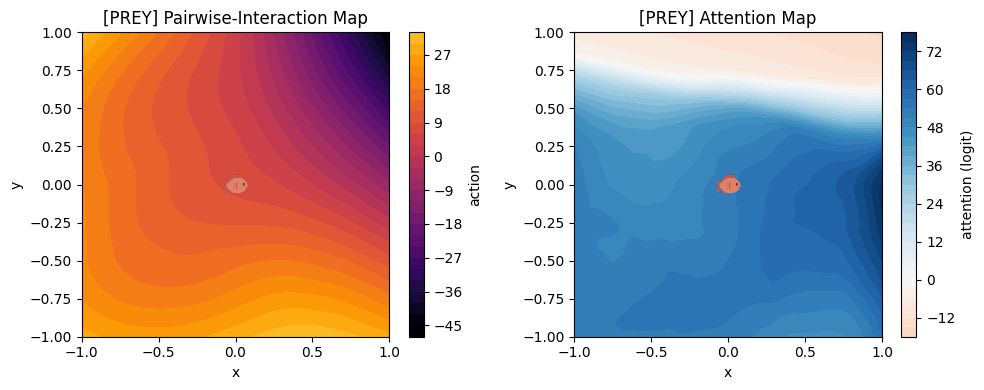

In [9]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin=prey_policy.prey_pairwise, an=prey_policy.prey_attention)

prey_img_path = rf"..\data\3. Evaluation\images\prey.png"
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

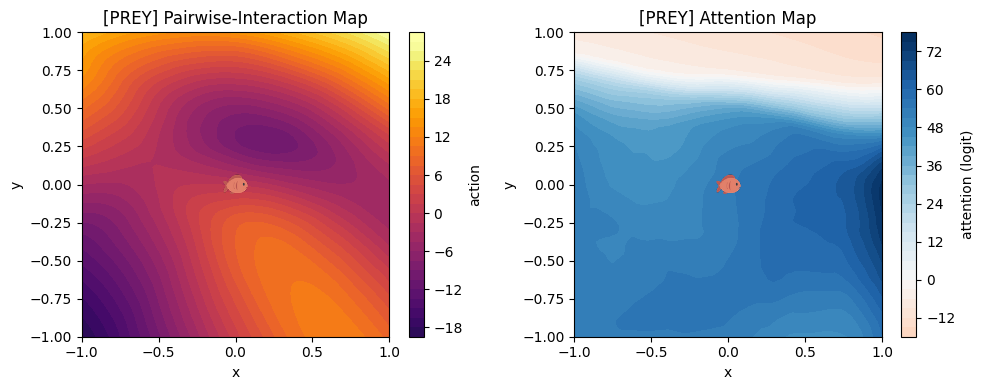

In [10]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin=prey_pred_policy.pred_pairwise, an=prey_policy.prey_attention)

prey_img_path = rf"..\data\3. Evaluation\images\prey.png"
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

In [11]:
def run_policies2(env, pred_policy, prey_policy, prey_pred_policy, render=True):
    if render:
        print("Press 'q' to end simulation.")

    pred_policy.to("cpu")
    prey_policy.to("cpu")
    prey_pred_policy.to("cpu")

    while True:
        if render and keyboard.is_pressed('q'):
            break

        global_state = env.state().item()
        pred_tensor, prey_tensor, xs, ys, directions, dx, dy, vxs, vys = get_eval_features(global_state)

        pred_states = pred_tensor[..., :4]
        action_pred, mu_pred, sigma_pred, weights_pred = pred_policy.forward(pred_states)
        dis_pred = continuous_to_discrete(action_pred, 360, role='predator')

        prey_states = prey_tensor[..., :4]
        prey_action_per_prey, mu_log, sigma_log, weights_log = prey_policy.forward(prey_states)
        prey_action_from_pred, mu_pred_log, sigma_pred_log = prey_pred_policy.forward(prey_states)
        prey_action_from_pred = prey_action_from_pred[..., 0]
        prey_action_from_pred = prey_action_from_pred.mean(dim=1)

        # Weight Approach
        weights_pred = weights_pred
        w_min = weights_pred.min(dim=1, keepdim=True).values
        w_max = weights_pred.max(dim=1, keepdim=True).values
        weights = (weights_pred - w_min) / (w_max - w_min + 1e-8)

        # Distance Approach
        xs = torch.as_tensor(xs, dtype=torch.float32)
        ys = torch.as_tensor(ys, dtype=torch.float32)
        px, py = xs[0], ys[0]
        dists = torch.sqrt((xs - px)**2 + (ys - py)**2) # euclidean distance
        dists_norm = dists / (dists.max() + 1e-8)
        prey_dists = dists_norm[1:] #without predator

        final_action = (1.0 - prey_dists) * (prey_action_from_pred) + prey_dists * prey_action_per_prey

        dis_prey = continuous_to_discrete(final_action, 360, role='prey')


        # Action dictionary
        action_dict = {'predator_0': dis_pred}
        for i, agent_name in enumerate(sorted([agent for agent in env.agents if agent.startswith("prey")])):
            action_dict[agent_name] = dis_prey[i]

        env.step(action_dict)

        # Render only if user wants it
        if render:
            env.render()

    # Try closing the environment
    try:
        env.close()
    except:
        pass

In [12]:
#env = parallel_env(use_walls=True, prey_max_velocity=4.0, predator_max_velocity=5.0, prey_count=32, width=800, height=800)

env = parallel_env(
    # Rendering
    render_mode="human",
    caption="Aquarium",
    fps=60,

    # Welt
    use_walls=True,
    observable_walls=4,
    width=800,
    height=800,

    # Episode
    max_time_steps=3000,

    # Actions
    action_count=360,

    # Agentenzahlen
    predator_count=1,
    prey_count=20,
    max_prey_count=32,
    keep_prey_count_constant=True,

    # Beobachtung
    predator_observe_count=1,
    prey_observe_count=32,
    fov_enabled=True,

    # Debug Drawing
    draw_force_vectors=True,
    draw_action_vectors=True,
    draw_view_cones=False,
    draw_hit_boxes=False,
    draw_death_circles=False,

    # Prey – Geometrie
    prey_radius=1,
    prey_view_distance=1000,
    prey_fov=360,

    # Prey – Bewegung (Policy-dominiert)
    prey_max_velocity=4.0,
    prey_max_acceleration=10.0,
    prey_max_steer_force=360.0,

    # Prey – Rewards / Leben
    prey_reward=0,
    prey_punishment=0,
    prey_replication_age=10000,

    # Predator – Geometrie
    predator_radius=30,
    predator_view_distance=1000,
    predator_fov=360,

    # Predator – Bewegung (Policy-dominiert)
    predator_max_velocity=5.0,
    predator_max_acceleration=10.0,
    predator_max_steer_force=360.0,

    # Predator – Leben / Reward
    predator_reward=0,
    predator_max_age=10000,

    # Interaktion
    catch_radius=0,
    procreate=False,
)



positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
run_policies2(env, pred_policy, prey_policy, prey_pred_policy)

Press 'q' to end simulation.
